In [1]:
import pandas as pd 
import numpy as np 
import os , sys  
import re 
import networkx as nx 
%store -r data_trad
from IPython.display import clear_output
%store -r Dict  
import matplotlib.pyplot as plt
import spacy 
data=data_trad
discri = Dict.keys()

In [107]:
#data_trad.to_csv('main_data.csv')
data_trad=pd.read_csv('main_data.csv')

In [10]:
## SYNONYMS METHOD HERE §  



%store -r Dict 
discri = Dict.keys()

In [12]:
#data_trad=data_trad.set_index('id')
trad =data_trad['clean_presentation_trad']
ID_list = data_trad.index  

In [13]:
def check_it(Dict,trad,ID_list,discri): 
    connection={}
    i = 0 
    for idx in ID_list:  
        
        checking=[Dict[el.lower()] for el in trad[idx] if el in discri] 
        i+=1 
        if i % 10 == 0 : 
            print(f'étape {i} sur {len(ID_list)}') 
            clear_output(wait=True)
        for idx2 in ID_list : 
            if idx2==idx  : 
                continue              
            connection[(idx,idx2)] = 0
            to_check=set.union( * [Dict[el.lower()] for el in trad[idx2]]) 
            for val in checking :  
                connection[(idx,idx2)] += any(el in to_check for el in val)*1  
            if  (idx2,idx)  in connection.keys() : 
                connection[(idx,idx2)]=min(connection[(idx,idx2)], 
                                          connection[(idx2,idx)]) 
                
                del connection[(idx2,idx)]
            
    for key in list(connection.keys()) : 
        if connection[key] > 100 :
            connection[key]=100 
        if connection[key] >3:
            continue  
        del connection[key]
    return connection


In [14]:
def Create_network(trad,ID_list,discri,max_df,max_features=len(trad),
                   limits=8): 
    
    from sklearn.feature_extraction.text import TfidfVectorizer 

    vectorizer= TfidfVectorizer(max_df=max_df,max_features=max_features)
    X = vectorizer.fit_transform(trad.apply(lambda x: ' '.join(x)))
    print('feature name done ')
    discri=vectorizer.get_feature_names() 
    
    tojson=check_it(Dict,trad,ID_list,discri) 
    print('tojson done')
    A, B =list(zip(*tojson.keys())) 
    weights = tojson.values() 
    
    Network=pd.DataFrame()
    Network['A']=A
    Network['B']=B 
    Network['WEIGHTS']=weights  
    Network=Network[Network['WEIGHTS'] > limits ]
    print('dataframe created') 
    print(f'lenght of feature in graph construction :{len(discri)}')
    Network.A=Network.A.apply(lambda x : data_trad[['nom']].loc[x].values[0])
    Network.B=Network.B.apply(lambda x : data_trad[['nom']].loc[x].values[0])  
    UNIQUE =set.union(set(Network.A),set(Network.B))
    #G=nx.from_pandas_edgelist(Network , 'A', 'B') 
    G=nx.Graph() 
    G.add_nodes_from(list(UNIQUE)) 
    for i in range(len(Network)): 
        G.add_edge(Network.iloc[i].A,Network.iloc[i].B, weight=int(Network.iloc[i].WEIGHTS)/5)
    return G , X , vectorizer, Network

tojson done
dataframe created
lenght of feature in graph construction :209


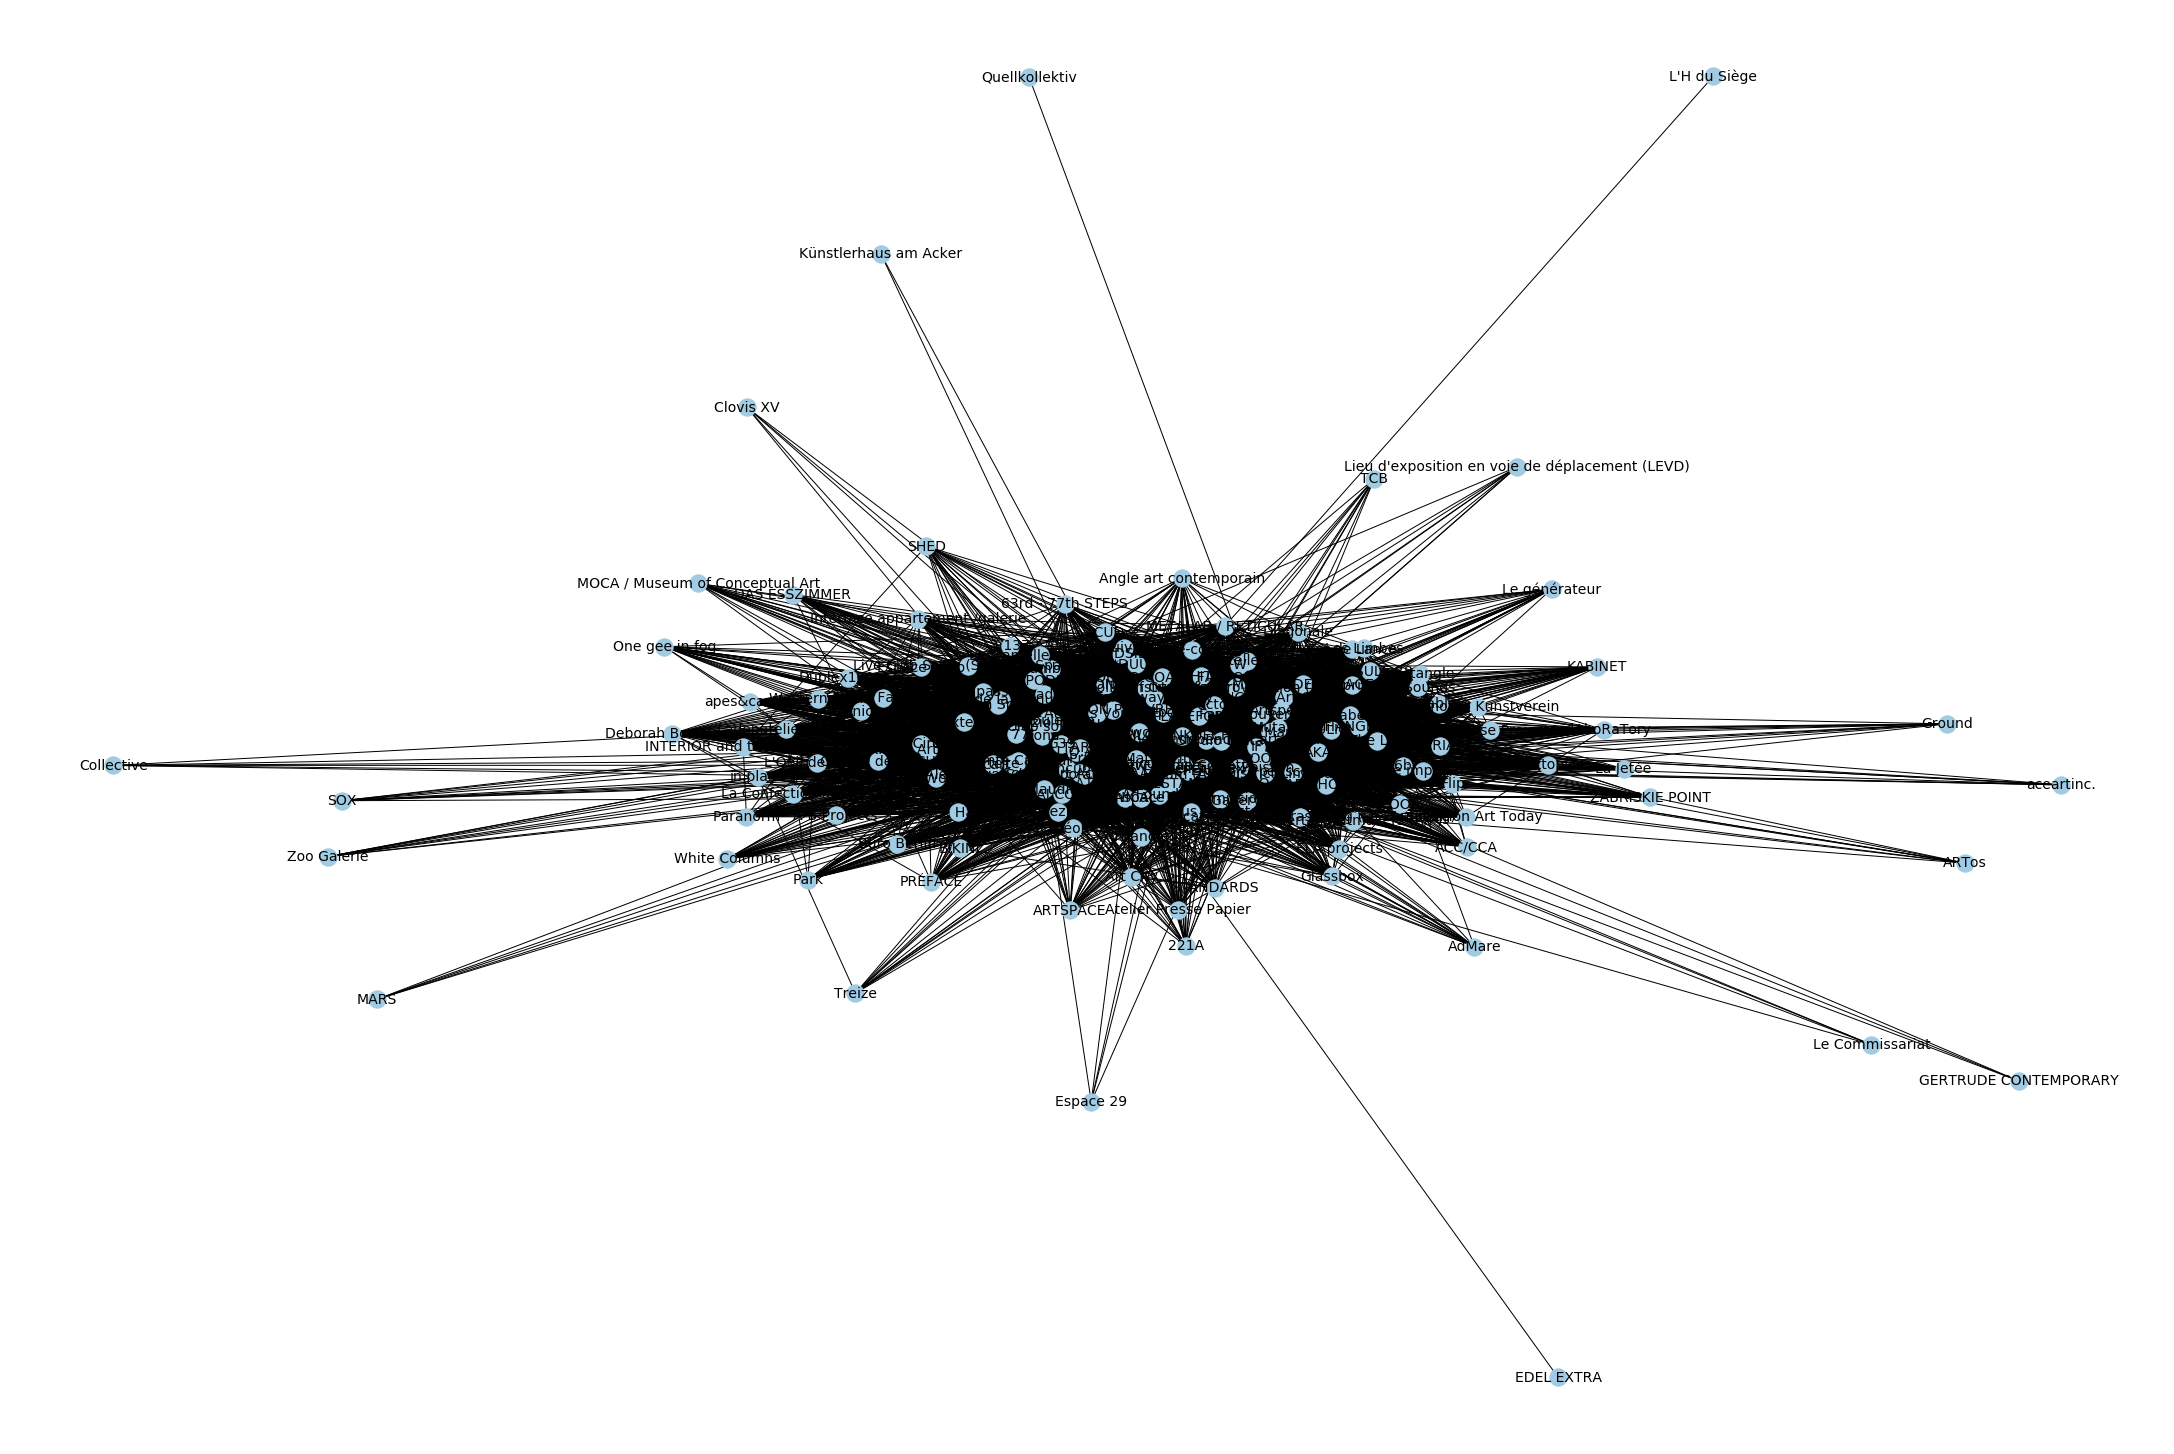

In [84]:
G, X, vectorizer, Network=Create_network(trad,ID_list,discri,
                                         max_df=0.4,max_features=len(trad)) 
plt.rcParams['figure.figsize']=(30,20)
nx.draw(G ,
        node_color='#A0CBE2',
        width=1, edge_cmap=plt.cm.Blues,
        font_size=14, with_labels=True) 

# Clustering for different label  

In [68]:
from sklearn.cluster import DBSCAN , KMeans ,AgglomerativeClustering  

# Kmeans 

In [93]:
def elbow(X,maximal=20): 
    plt.style.use('dark_background')
    distortion=[]
    for i in range(1,maximal): 
        Km=KMeans(n_clusters=i) 
        Km.fit(X) 
        distortion.append(Km.inertia_) 
    plt.plot(distortion)

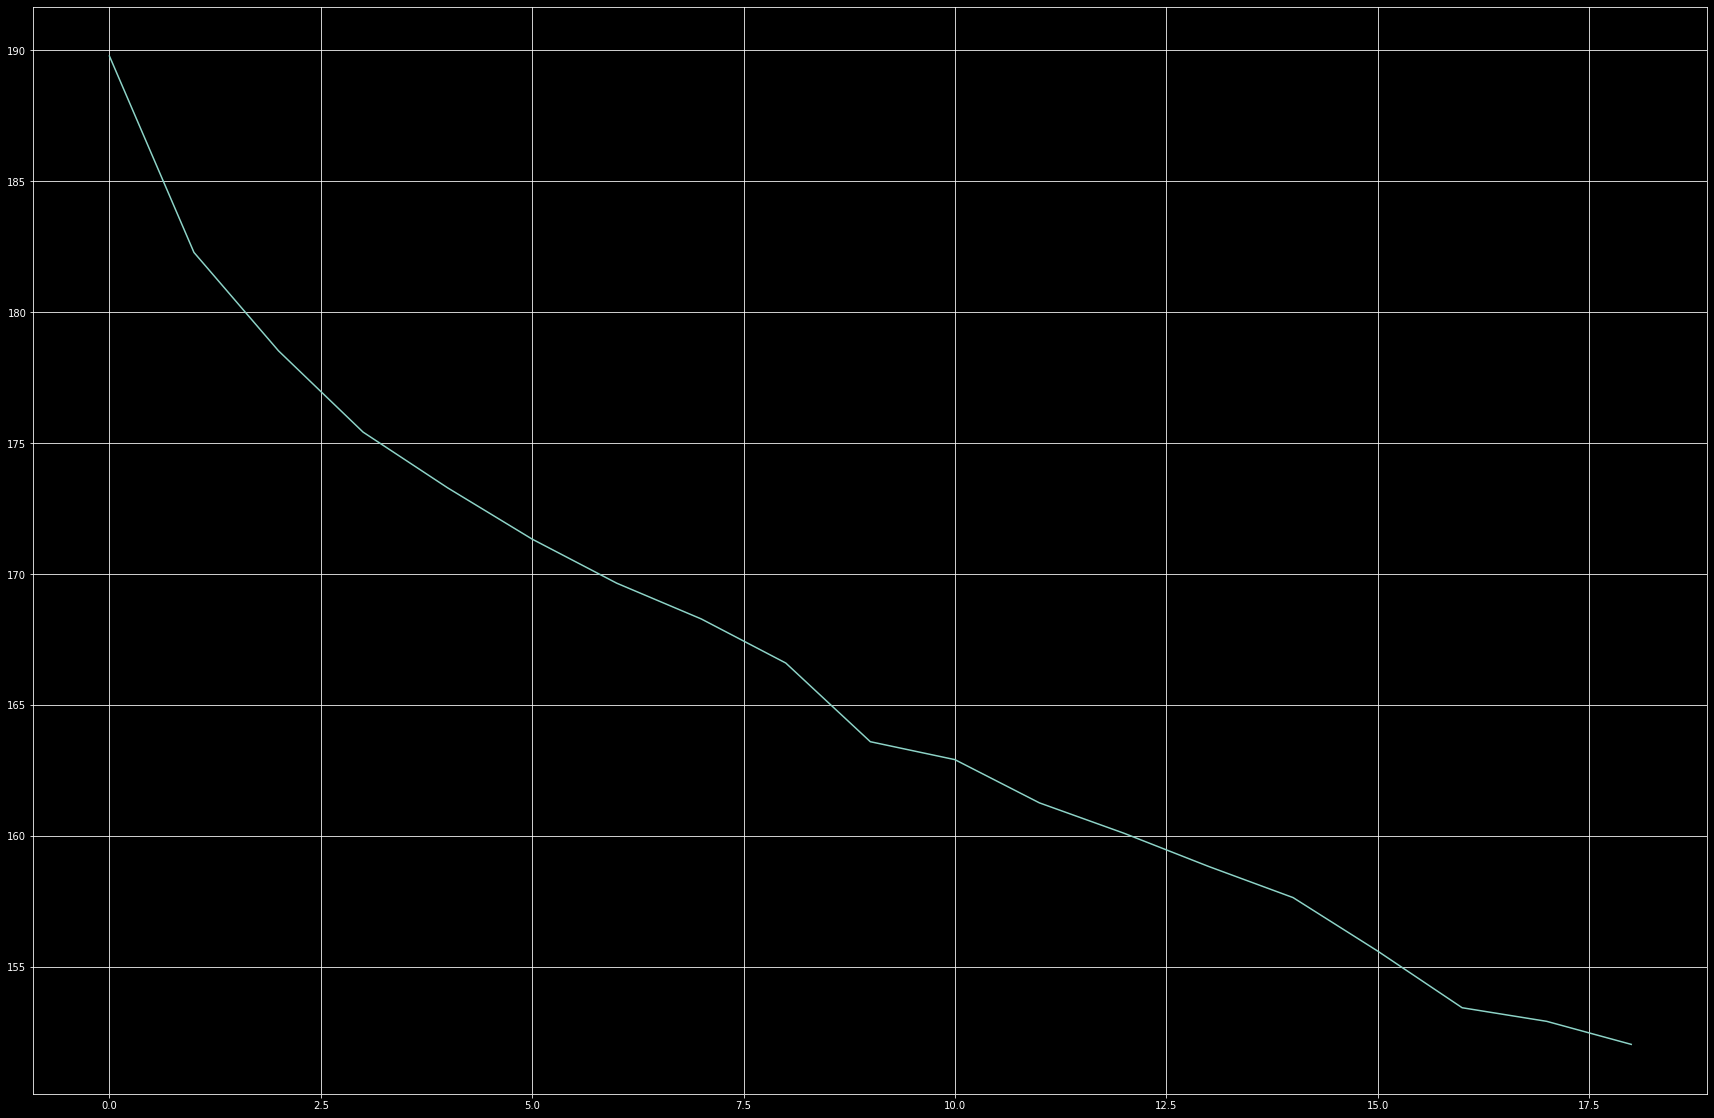

In [95]:
elbow(X,maximal=20) 
plt.grid()

In [123]:
Km=KMeans(n_clusters=9) 
Km.fit(X) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [124]:
data_trad['Kmeans']=Km.labels_ 
 

In [300]:
def Create_network_clust(label,limits=6): 
    data_trad_label=data_trad[data_trad.Kmeans==label]
    trad_label =data_trad_label['clean_presentation_trad']
    ID_list_label = data_trad_label.index 
    discri=vectorizer.get_feature_names() 
    
    tojson=check_it(Dict,trad_label,ID_list_label,discri) 
    print('tojson done')
    A, B =list(zip(*tojson.keys())) 
    weights = tojson.values() 
    
    Network=pd.DataFrame()
    Network['A']=A
    Network['B']=B 
    Network['WEIGHTS']=weights  
    Network=Network[Network['WEIGHTS'] > limits ]
    print('dataframe created') 
    print(f'lenght of feature in graph construction :{len(discri)}')
    Network.A=Network.A.apply(lambda x : data_trad[['nom']].loc[x].values[0])
    Network.B=Network.B.apply(lambda x : data_trad[['nom']].loc[x].values[0])  
    UNIQUE =set.union(set(Network.A),set(Network.B))
    #G=nx.from_pandas_edgelist(Network , 'A', 'B') 
    G=nx.Graph() 
    G.add_nodes_from(list(UNIQUE)) 
    for i in range(len(Network)): 
        G.add_edge(Network.iloc[i].A,Network.iloc[i].B, value=int(Network.iloc[i].WEIGHTS)/5)
    return G , X , vectorizer, Network

In [314]:
from networkx.readwrite import json_graph
import json

def Kmeans_json(clust=8): 
    Dict={}
    for j in range(8):
        print(j)
        Gl, Xl, vectorizerl, Networkl=Create_network_clust(j) 
        #for i in Gl.nodes:  
         #   nx.set_node_attributes(Gl,{i : data_trad['date_open'][data_trad['nom']==i]},name='date' )
        CC={} 
        for key,val in nx.clustering(Gl).items(): 
            try :
                date=int(data_trad['date_open'][data_trad['nom']==key].values[0])
            except:
                date = 2018
            CC[key]={'clustering_coeff':val ,'date':date,'degree':Gl.degree()[key]}
        nx.set_node_attributes( Gl,CC) 
        JSON = json_graph.node_link_data(Gl)
        s1 = json.dumps(JSON,default=convert)
        
        Dict[f'cluster{j+1}']=JSON 
        with open(f'Kmeans.json', 'w') as outfile:
            json.dump(Dict, outfile) 
    return Dict

In [315]:
KMEAN2 =Kmeans_json()

tojson done
dataframe created
lenght of feature in graph construction :209



# DBSCAN METHOD 

In [283]:
CA=AgglomerativeClustering(n_clusters=8)  
CA.fit(X.todense())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=8)

In [286]:
data_trad['AgglomerativeClustering']=CA.labels_

array([8, 8, 5, 8, 4, 2, 7, 8, 6, 7, 0, 5, 2, 5, 2, 1, 5, 1, 6, 4, 8, 5,
       5, 6, 8, 2, 0, 1, 6, 4, 8, 5, 4, 6, 0, 0, 6, 8, 5, 1, 4, 1, 8, 8,
       1, 1, 8, 8, 1, 1, 0, 1, 2, 2, 0, 4, 2, 4, 5, 6, 8, 1, 6, 1, 4, 8,
       8, 5, 1, 1, 5, 4, 5, 1, 1, 5, 1, 0, 7, 1, 2, 6, 6, 2, 1, 7, 5, 8,
       5, 5, 6, 5, 4, 5, 8, 8, 5, 8, 4, 5, 2, 1, 1, 0, 6, 8, 0, 1, 4, 5,
       6, 4, 6, 4, 4, 4, 7, 5, 2, 2, 0, 2, 8, 8, 6, 6, 5, 1, 5, 2, 5, 8,
       5, 5, 2, 0, 2, 2, 3, 4, 3, 2, 2, 2, 8, 2, 2, 4, 2, 2, 2, 3, 2, 8,
       3, 2, 5, 1, 3, 1, 6, 0, 5, 5, 5, 4, 0, 0, 0, 5, 4, 2, 1, 1, 2, 6,
       6, 0, 4, 7, 0, 0, 7, 0, 7, 7, 1, 0, 7, 1, 7, 4, 6, 0, 3, 0, 8, 8,
       1, 2, 2, 8, 5, 1, 1, 6, 1, 0, 5], dtype=int32)

In [317]:
from networkx.readwrite import json_graph
import json


def Create_network_clust_CA(label,limits=6): 
    data_trad_label=data_trad[data_trad.AgglomerativeClustering==label]
    trad_label =data_trad_label['clean_presentation_trad']
    ID_list_label = data_trad_label.index 
    discri=vectorizer.get_feature_names() 
    
    tojson=check_it(Dict,trad_label,ID_list_label,discri) 
    print('tojson done')
    A, B =list(zip(*tojson.keys())) 
    weights = tojson.values() 
    
    Network=pd.DataFrame()
    Network['A']=A
    Network['B']=B 
    Network['WEIGHTS']=weights  
    Network=Network[Network['WEIGHTS'] > limits ]
    print('dataframe created') 
    print(f'lenght of feature in graph construction :{len(discri)}')
    Network.A=Network.A.apply(lambda x : data_trad[['nom']].loc[x].values[0])
    Network.B=Network.B.apply(lambda x : data_trad[['nom']].loc[x].values[0])  
    UNIQUE =set.union(set(Network.A),set(Network.B))
    #G=nx.from_pandas_edgelist(Network , 'A', 'B') 
    G=nx.Graph() 
    G.add_nodes_from(list(UNIQUE)) 
    for i in range(len(Network)): 
        G.add_edge(Network.iloc[i].A,Network.iloc[i].B, value=int(Network.iloc[i].WEIGHTS)/5)
    return G , X , vectorizer, Network


def CA_json(clust=8): 
    Dict={}
    for j in range(8):
        print(j)
        Gl, Xl, vectorizerl, Networkl=Create_network_clust_CA(j) 
        #for i in Gl.nodes:  
         #   nx.set_node_attributes(Gl,{i : data_trad['date_open'][data_trad['nom']==i]},name='date' )
        CC={} 
        for key,val in nx.clustering(Gl).items(): 
            try :
                date=int(data_trad['date_open'][data_trad['nom']==key].values[0])
            except:
                date = 2018
            CC[key]={'clustering_coeff':val ,'date':date,'degree':Gl.degree()[key]}
        nx.set_node_attributes( Gl,CC) 
        JSON = json_graph.node_link_data(Gl)
        s1 = json.dumps(JSON,default=convert)
        
        Dict[f'cluster{j+1}']=JSON 
        with open(f'CAH.json', 'w') as outfile:
            json.dump(Dict, outfile) 
    return Dict

In [318]:
CAH2=CA_json()

tojson done
dataframe created
lenght of feature in graph construction :209
7
tojson done
dataframe created
lenght of feature in graph construction :209


In [307]:
CAH2['cluster1']['']

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'clustering_coeff': 0.8780841799709724,
   'date': 2013,
   'id': 'PLATEFORME'},
  {'clustering_coeff': 0.8560447239692522, 'date': 1991, 'id': 'Club solo'},
  {'clustering_coeff': 0.9148936170212766, 'date': 2018, 'id': '*DUUU'},
  {'clustering_coeff': 0.8560447239692522, 'date': 1980, 'id': '/ 77'},
  {'clustering_coeff': 0.8560447239692522,
   'date': 1998,
   'id': 'ruimte Caesuur'},
  {'clustering_coeff': 0.9581881533101045, 'date': 2018, 'id': 'Easttopics'},
  {'clustering_coeff': 0.9226190476190477, 'date': 2013, 'id': "L'impasse"},
  {'clustering_coeff': 0.8255892255892255,
   'date': 1991,
   'id': 'PILOTENKUECHE'},
  {'clustering_coeff': 0.9916666666666667, 'date': 1995, 'id': 'Treize'},
  {'clustering_coeff': 0.8964705882352941,
   'date': 2017,
   'id': 'L’Assaut de la menuiserie'},
  {'clustering_coeff': 0.8853695324283559, 'date': 2018, 'id': 'Fructôse'},
  {'clustering_coeff': 0.8560447239692522,
   'dat

In [319]:
FINAL2 = { 'CAH': CAH2 , 
          'KMeans':KMEAN2}

In [320]:
with open(f'FINALV2.json', 'w') as outfile:
            json.dump(FINAL2, outfile) 

In [321]:
FINAL2

{'CAH': {'cluster1': {'directed': False,
   'multigraph': False,
   'graph': {},
   'nodes': [{'clustering_coeff': 0.8780841799709724,
     'date': 2013,
     'degree': 53,
     'id': 'PLATEFORME'},
    {'clustering_coeff': 0.8560447239692522,
     'date': 1991,
     'degree': 54,
     'id': 'Club solo'},
    {'clustering_coeff': 0.9148936170212766,
     'date': 2018,
     'degree': 48,
     'id': '*DUUU'},
    {'clustering_coeff': 0.8560447239692522,
     'date': 1980,
     'degree': 54,
     'id': '/ 77'},
    {'clustering_coeff': 0.8560447239692522,
     'date': 1998,
     'degree': 54,
     'id': 'ruimte Caesuur'},
    {'clustering_coeff': 0.9581881533101045,
     'date': 2018,
     'degree': 42,
     'id': 'Easttopics'},
    {'clustering_coeff': 0.9226190476190477,
     'date': 2013,
     'degree': 49,
     'id': "L'impasse"},
    {'clustering_coeff': 0.8255892255892255,
     'date': 1991,
     'degree': 55,
     'id': 'PILOTENKUECHE'},
    {'clustering_coeff': 0.9916666666666667,

In [324]:
FINAL['CAH']['cluster1']

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'clustering_coeff': 0.8780841799709724,
   'date': 2013,
   'id': 'PLATEFORME'},
  {'clustering_coeff': 0.8560447239692522, 'date': 1991, 'id': 'Club solo'},
  {'clustering_coeff': 0.9148936170212766, 'date': 2018, 'id': '*DUUU'},
  {'clustering_coeff': 0.8560447239692522, 'date': 1980, 'id': '/ 77'},
  {'clustering_coeff': 0.8560447239692522,
   'date': 1998,
   'id': 'ruimte Caesuur'},
  {'clustering_coeff': 0.9581881533101045, 'date': 2018, 'id': 'Easttopics'},
  {'clustering_coeff': 0.9226190476190477, 'date': 2013, 'id': "L'impasse"},
  {'clustering_coeff': 0.8255892255892255,
   'date': 1991,
   'id': 'PILOTENKUECHE'},
  {'clustering_coeff': 0.9916666666666667, 'date': 1995, 'id': 'Treize'},
  {'clustering_coeff': 0.8964705882352941,
   'date': 2017,
   'id': 'L’Assaut de la menuiserie'},
  {'clustering_coeff': 0.8853695324283559, 'date': 2018, 'id': 'Fructôse'},
  {'clustering_coeff': 0.8560447239692522,
   'dat

In [326]:
help(nx.Graph())

Help on Graph in module networkx.classes.graph object:

class Graph(builtins.object)
 |  Graph(incoming_graph_data=None, **attr)
 |  
 |  Base class for undirected graphs.
 |  
 |  A Graph stores nodes and edges with optional data, or attributes.
 |  
 |  Graphs hold undirected edges.  Self loops are allowed but multiple
 |  (parallel) edges are not.
 |  
 |  Nodes can be arbitrary (hashable) Python objects with optional
 |  key/value attributes. By convention `None` is not used as a node.
 |  
 |  Edges are represented as links between nodes with optional
 |  key/value attributes.
 |  
 |  Parameters
 |  ----------
 |  incoming_graph_data : input graph (optional, default: None)
 |      Data to initialize graph. If None (default) an empty
 |      graph is created.  The data can be any format that is supported
 |      by the to_networkx_graph() function, currently including edge list,
 |      dict of dicts, dict of lists, NetworkX graph, NumPy matrix
 |      or 2d ndarray, SciPy sparse 

In [334]:
d=FINAL2['CAH']['cluster1']
g = nx.Graph()
g.add_nodes_from(d.keys()) 
for k, v in d.items():
    g.add_edges_from(([(k, t) for t in v]))

TypeError: 'bool' object is not iterable

In [332]:
g.add_nodes_from(d['nodes'])

ValueError: too many values to unpack (expected 2)

In [356]:
for i in d['nodes']: 
    print(i)

{'clustering_coeff': 0.8780841799709724, 'date': 2013, 'degree': 53, 'id': 'PLATEFORME'}
{'clustering_coeff': 0.8560447239692522, 'date': 1991, 'degree': 54, 'id': 'Club solo'}
{'clustering_coeff': 0.9148936170212766, 'date': 2018, 'degree': 48, 'id': '*DUUU'}
{'clustering_coeff': 0.8560447239692522, 'date': 1980, 'degree': 54, 'id': '/ 77'}
{'clustering_coeff': 0.8560447239692522, 'date': 1998, 'degree': 54, 'id': 'ruimte Caesuur'}
{'clustering_coeff': 0.9581881533101045, 'date': 2018, 'degree': 42, 'id': 'Easttopics'}
{'clustering_coeff': 0.9226190476190477, 'date': 2013, 'degree': 49, 'id': "L'impasse"}
{'clustering_coeff': 0.8255892255892255, 'date': 1991, 'degree': 55, 'id': 'PILOTENKUECHE'}
{'clustering_coeff': 0.9916666666666667, 'date': 1995, 'degree': 16, 'id': 'Treize'}
{'clustering_coeff': 0.8964705882352941, 'date': 2017, 'degree': 51, 'id': 'L’Assaut de la menuiserie'}
{'clustering_coeff': 0.8853695324283559, 'date': 2018, 'degree': 52, 'id': 'Fructôse'}
{'clustering_coeff

In [350]:
G=nx.DiGraph()
G.add_nodes_from(dictionary.keys())
for key,n in G.nodes.items():
   n["attribute"]=dictionary[key]

{'clustering_coeff': 0.8780841799709724,
 'date': 2013,
 'degree': 53,
 'id': 'PLATEFORME'}

In [358]:
data_trad.drop(['presentation_en','clean_presentation_trad'],axis=1,inplace=True)

In [359]:
data_trad.to_csv('data_finalv5.csv')